In [1]:
import random
import os

from transformers import (
    MaskFormerConfig,
    MaskFormerImageProcessor,
    MaskFormerModel,
    MaskFormerForInstanceSegmentation
)

from huggingface_hub import notebook_login
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from datasets import load_dataset
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
from torch import nn
import pandas as pd
import numpy as np
import evaluate
import torch


In [2]:
ROOT_PATH = '/'.join(os.getcwd().split('/')[:-2])
DATA_PATH = f'{ROOT_PATH}/dataset/placeschallenge'

In [3]:
train = load_dataset('scene_parse_150', 'instance_segmentation', split = 'train')
valid = load_dataset('scene_parse_150', 'instance_segmentation', split = 'validation')
test  = load_dataset('scene_parse_150', 'instance_segmentation', split = 'test')

Found cached dataset scene_parse_150 (/home/jovyan/.cache/huggingface/datasets/scene_parse_150/instance_segmentation/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)
Found cached dataset scene_parse_150 (/home/jovyan/.cache/huggingface/datasets/scene_parse_150/instance_segmentation/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)
Found cached dataset scene_parse_150 (/home/jovyan/.cache/huggingface/datasets/scene_parse_150/instance_segmentation/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)


In [4]:
print(train[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F5ED83C1430>, 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F5C6A384220>}


In [5]:
idx        = random.randint(0, len(train))
image      = np.array(train[idx]['image'].convert('RGB'))
annotation = np.array(train[idx]['annotation'])

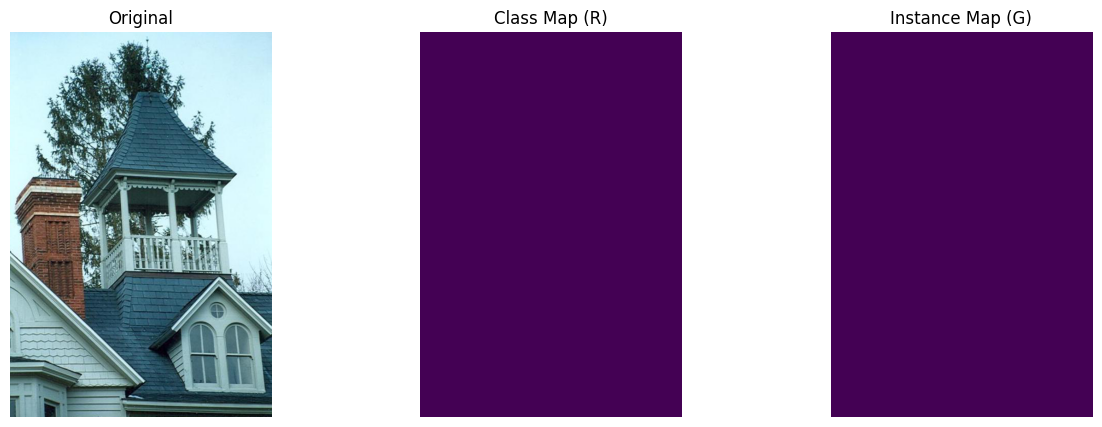

In [6]:
plt.figure(figsize = (15, 5))
for plot_index in range(3):
    
    if plot_index == 0:
        plot_image = image
        title = 'Original'
        
    else:
        plot_image = annotation[..., plot_index - 1]
        title     = ['Class Map (R)', 'Instance Map (G)'][plot_index - 1]
        
    
    plt.subplot(1, 3, plot_index + 1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis('off')

In [7]:
processor = MaskFormerImageProcessor(
    reduce_labels = True,
    size          = (512, 512),
    ignore_index  = 255,
    do_resize     = False,
    do_rescale    = False,
    do_normalize  = False
)

/opt/conda/envs/tensor/lib/python3.8/site-packages/transformers/models/maskformer/image_processing_maskformer.py:421: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [8]:
model_name = 'facebook/maskformer-swin-base-ade'
config     = MaskFormerConfig.from_pretrained(model_name)

In [9]:
data = pd.read_csv(
    f'{DATA_PATH}/instanceInfo100_train.txt', sep = '\t',
    header = 0, on_bad_lines = 'skip'
)

idx2lb = {idx : lb.strip() for idx, lb in enumerate(data['Object Names'])}
lb2idx = {v : k for k, v in idx2lb.items()}

config.idx2lb = idx2lb
config.lb2idx = lb2idx

In [10]:
model      = MaskFormerForInstanceSegmentation(config)
base_model = MaskFormerModel.from_pretrained(model_name)
model.mode = base_model

Some weights of the model checkpoint at facebook/maskformer-swin-base-ade were not used when initializing MaskFormerModel: ['mask_embedder.1.0.bias', 'class_predictor.bias', 'mask_embedder.2.0.weight', 'criterion.empty_weight', 'mask_embedder.0.0.bias', 'mask_embedder.2.0.bias', 'mask_embedder.1.0.weight', 'class_predictor.weight', 'mask_embedder.0.0.weight']
- This IS expected if you are initializing MaskFormerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MaskFormerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD  = np.array([58.395, 57.120, 57.375]) / 255

In [12]:
train_val_transform = A.Compose([
    A.Resize(width = 512, height = 512),
    A.HorizontalFlip(p = 0.3),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD)
])

In [13]:
class ImageSegmentationDataset(Dataset):
    
    def __init__(self, dataset, processor, transform = None):
        
        self.dataset   = dataset
        self.processor = processor
        self.transform = transform
        
    
    def __len__(self): return len(self.dataset)


    def __getitem__(self, idx):
        
        image = np.array(self.dataset[idx]['image'].convert('RGB'))
        
        instance_seg = np.array(self.dataset[idx]['annotation'])[..., 1]
        class_id_map = np.array(self.dataset[idx]['annotation'])[..., 0]
        
        class_labels = np.unique(class_id_map)
        instance2class = {}
        for lb in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == lb])
            instance2class.update({i : lb for i in instance_ids})
            
        if self.transform is not None:
            
            transformed           = self.transform(image = image, mask = instance_seg)
            (image, instance_seg) = (transformed['image'], transformed['mask'])
            
            image = image.transpose(2, 0, 1)
            
        
        conditions = [class_labels.shape[0] == 1, class_labels[0] == 0]
        if all(conditions):
            
            inputs = self.processor([image], return_tensors = 'pt')
            inputs = {k : v.squeeze() for k, v in inputs.items()}
            
            inputs['class_labels'] = torch.tensor([0])
            inputs['mask_labels']  = torch.zeros(
                                    (0, inputs['pixel_values'].shape[-2], inputs['pixel_values'].shape[-1])
                                )
        else:
            inputs = self.processor(
                        [image], [instance_seg],
                        instance_id_to_semantic_id = instance2class,
                        return_tensors = 'pt'
                    )
            
            inputs = {k : v.squeeze() if isinstance(v, torch.Tensor)
                                      else v[0] for k, v in inputs.items()}
        
        return inputs

In [14]:
train_dataset = ImageSegmentationDataset(train, processor = processor,
                                        transform = train_val_transform)

valid_dataset = ImageSegmentationDataset(valid, processor = processor,
                                        transform = train_val_transform)

In [15]:
inputs  = dict(sorted(valid_dataset[0].items(), key = lambda x: len(x[0])))
max_len = max([len(k) for k in inputs.keys()])

for k, v in inputs.items(): 
    print(f'{k} {" "*(max_len - len(k))}shape : {v.shape}')

pixel_mask   shape : torch.Size([512, 512])
mask_labels  shape : torch.Size([4, 512, 512])
pixel_values shape : torch.Size([3, 512, 512])
class_labels shape : torch.Size([4])


In [16]:
def collate_fn(samples):
    
    pixel_values = torch.stack([sample['pixel_values'] for sample in samples])
    pixel_mask   = torch.stack([sample['pixel_mask']   for sample in samples])
    
    mask_labels  = [sample['mask_labels'] for sample in samples]
    class_labels = [sample['class_labels'] for sample in samples]
    
    return {
        'pixel_values' : pixel_values,
        'pixel_mask'   : pixel_mask,
        'mask_labels'  : mask_labels,
        'class_labels' : class_labels
        
    }
                           
                           

train_loader = DataLoader(
    train_dataset, batch_size = 4,
    shuffle = True, collate_fn = collate_fn
)

valid_loader = DataLoader(
    valid_dataset, batch_size = 4,
    shuffle = False, collate_fn = collate_fn
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


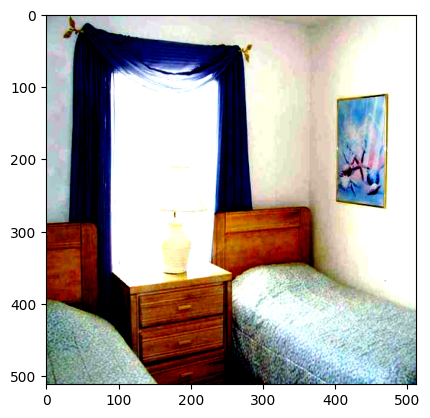

In [17]:
sample = next(iter(train_loader))
sample = np.transpose(sample['pixel_values'][0].squeeze(), (1, 2, 0))

plt.imshow(sample)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer  = torch.optim.Adam(model.parameters(), lr = 5e-5)
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    
    print(f'[{epoch} / {num_epochs}] Training')
    model.train()
    
    train_loss, valid_loss = [], []
    for idx, batch in enumerate(tqdm(train_loader)):
        
        optimizer.zero_grad()
        outputs = model(
            pixel_values = batch['pixel_values'].to(device),
            mask_labels  = [labels.to(device) for labels in batch['mask_labels']],
            class_labels = [labels.to(device) for labels in batch['class_labels']]
        )
        
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        
        if idx % 1000 == 0:
            print(f'[{epoch} / {num_epochs}] training loss : {round(sum(train_loss)/ len(train_loss), 3)}')
        
        
        optimizer.step()
        
    train_loss = sum(train_loss) / len(train_loss)
    model.eval()
    
    start_idx = 0
    print(f'[{epoch} / {num_epochs}] Validation')
    
    for idx, batch in enumerate(tqdm(valid_loader)):
        
        with torch.no_grad():
            outputs = model(
                pixel_values = batch['pixel_values'].to(device),
                mask_labels  = [labels.to(device) for labels in batch['mask_labels']],
                class_labels = [labels.to(device) for labels in batch['class_labels']]
                
            )
            
            loss = outputs.loss
            valid_loss.append(loss.item())
            
            if idx % 1000 == 0:
                print(f'[{epoch} / {num_epochs}] validation loss : {round(sum(valid_loss)/ len(valid_loss), 3)}')
            
    valid_loss = sum(valid_loss) / len(valid_loss)
    
    print(f'[{epoch} / {num_epochs}] train loss : {train_loss} | valid loss : {valid_loss}')

[1 / 10] Training


  0%|          | 1/5053 [00:03<4:46:11,  3.40s/it]

[1 / 10] training loss : 17.713


 20%|█▉        | 1001/5053 [08:32<32:26,  2.08it/s]

[1 / 10] training loss : 3.917


 40%|███▉      | 2001/5053 [17:03<24:47,  2.05it/s]

[1 / 10] training loss : 3.763


 59%|█████▉    | 3001/5053 [25:34<15:48,  2.16it/s]

[1 / 10] training loss : 3.677


 79%|███████▉  | 4001/5053 [34:03<09:11,  1.91it/s]

[1 / 10] training loss : 3.639


 99%|█████████▉| 5001/5053 [42:42<00:27,  1.89it/s]

[1 / 10] training loss : 3.611


100%|██████████| 5053/5053 [43:08<00:00,  1.95it/s]


[1 / 10] Validation


  0%|          | 1/500 [00:00<03:00,  2.77it/s]

[1 / 10] validation loss : 4.942


100%|██████████| 500/500 [02:25<00:00,  3.44it/s]


[1 / 10] train loss : 3.6097982972064115 | valid loss : 4.288737401485443
[2 / 10] Training


  0%|          | 1/5053 [00:00<43:37,  1.93it/s]

[2 / 10] training loss : 4.089


 20%|█▉        | 1001/5053 [08:26<32:56,  2.05it/s]

[2 / 10] training loss : 3.479


 40%|███▉      | 2001/5053 [16:48<23:13,  2.19it/s]

[2 / 10] training loss : 3.43


 59%|█████▉    | 3001/5053 [25:14<17:01,  2.01it/s]

[2 / 10] training loss : 3.408


 78%|███████▊  | 3958/5053 [33:20<08:59,  2.03it/s]

In [ ]:
def infer(dataset, model, processor):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model  = model.to(device)
    
    index       = random.randint(0, len(test))
    image       = test[index]['image'].convert('RGB')
    target_size = image.size[::-1]
    
    inputs      = processor(images = image, return_tensors = 'pt').to(device)
    
    inputs['pixel_values'] = inputs['pixel_values'].to(device, dtype = torch.float32)
    inputs['pixel_mask']   = inputs['pixel_mask'].to(device, dtype = torch.float32)

    model.eval()
    with torch.no_grad(): outputs = model(**inputs)
    
    for k, v in outputs.items(): print(f'{k} : {v.shape}')
    
    result = processor.post_process_instance_segmentation(
                outputs, threshold = 0.5, target_sizes = [target_size]
            )[0]
    
    instance_seg_mask = result['segmentation'].cpu().detach().numpy()
    for info in result['segments_info']: print(f'{info}')
    
    return instance_seg_mask

    
def visualize_instance_seg_mask(mask):
    
    image    = np.zeros((mask.shape[0], mask.shape[1], 3))
    labels   = np.unique(mask)
    lb2color = {
            label : (
                    random.randint(0, 255),
                    random.randint(0, 255),
                    random.randint(0, 255),
                )
                for label in labels
            }
    
    for height in range(image.shape[0]):
        
        for width in range(image.shape[1]):
            image[height, width, :] = lb2color[mask[height, width]]
            
    image = image / 255
    return image

In [ ]:
mask      = infer(test, model, processor)
mask_disp = visualize_instance_seg_mask(mask)

plt.figure(figsize = (10, 10))
for plot_idx in range(2):
    
    if plot_idx == 0:
        plot_image = image
        title      = 'original'
        
    else:
        plot_image = mask_disp
        title      = 'segmentation'
        
    
    plt.subplot(1, 2, plot_idx + 1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis(False)

In [ ]:
metrics = evaluate.load('mean_iou')

In [ ]:
gt, preds = [], []
for idx in tqdm(range(200)):
    
    image       = valid[idx]['image'].convert('RGB')
    target_size = image.size[::-1]
    
    annotation  = np.array(valid[idx]['annotation'])[:, :, 0]
    annotation -= 1
    
    annotation[annotation == -1] = 255
    gt.append(annotation)
    
    inputs = processor(images = image, return_tensors = 'pt')
    inputs['pixel_values'] = inputs['pixel_values'].to(device, dtype = torch.float32)
    inputs['pixel_mask']   = inputs['pixel_mask'].to(device, dtype = torch.float32)
    
    model.eval()
    with torch.no_grad(): outputs = model(**inputs)
    
    result            = processor.post_process_semantic_segmentation(
                                    outputs, 
                                    target_sizes = [target_size])[0]
    
    semantic_seg_mask = result.cpu().detach().numpy()
    preds.append(semantic_seg_mask)
    
results = metrics.compute(
            predictions  = preds,
            references   = gt,
            num_labels   = 100,
            ignore_index = 255
        )

print(f'mIoU          : {results["mean_iou"]:.3f}')
print(f'mean Accuracy : {results["mean_accuracy"]:.3f}')
print(f'Overall       : {results["overall_accuracy"]:.3f}')

In [ ]:
len(valid)